# GBA 6430 - Big Data Technology in Business
# Dr. Mohammad Salehan
# Preprocessing with Spark

What problems can your dataset have? Well, to name a few:<ul>
    <li><b>Duplicated observations</b>: These arise through systemic and operator's faults
 <li><b>Missing observations</b>: These can emerge due to sensor problems, respondents'
 unwillingness to provide an answer to a question, or simply some data
corruption
 <li><b>Aanomalous observations</b>: Observations that, when you look at them, stand out
when compared with the rest of the dataset or a population
 <li><b>Encoding</b>: Text fields that are not normalized (for example, words are not
stemmed or use synonyms), in different languages, or you can encounter
gibberish text input, and date and date time fields may not encoded the same
way
 <li><b>Untrustworthy answers</b> (true especially for surveys): When respondents lie for
any reason; this type of dirty data is much harder to work with and clean up

### Initializitation
The default visualization backend for `PySpark` is `plotly` which is not supported by AWS. Thus we switch to `matplotlib` instead.

In [1]:
import pyspark.pandas as ps
import matplotlib.pyplot as plt
ps.set_option('plotting.backend', 'matplotlib')

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1718239785956_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1718239785956_0002/container_1718239785956_0002_01_000001/pyspark.zip/pyspark/pandas/__init__.py:51: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.

## Some dirty data

In [2]:
dirty_data = ps.DataFrame([
          (1,'Porsche','Boxster S','Turbo',2.5,4,22,None)
        , (2,'Aston Martin','Vanquish','Aspirated',6.0,12,16,None)
        , (3,'Porsche','911 Carrera 4S Cabriolet','Turbo',3.0,6,24,None)
        , (3,'General Motors','SPARK ACTIV','Aspirated',1.4,None,32,None)
        , (5,'BMW','COOPER S HARDTOP 2 DOOR','Turbo',2.0,4,26,None)
        , (6,'BMW','330i','Turbo',2.0,None,27,None)
        , (7,'BMW','440i Coupe','Turbo',3.0,6,23,None)
        , (8,'BMW','440i Coupe','Turbo',3.0,6,23,None)
        , (9,'Mercedes-Benz',None,None,None,None,27,None)
        , (10,'Mercedes-Benz','CLS 550','Turbo',4.7,8,21,79231)
        , (11,'Volkswagen','GTI','Turbo',2.0,4,None,None)
        , (12,'Ford Motor Company','FUSION AWD','Turbo',2.7,6,20,None)
        , (13,'Nissan','Q50 AWD RED SPORT','Turbo',3.0,6,22,None)
        , (14,'Nissan','Q70 AWD','Aspirated',5.6,8,18,None)
        , (15,'Kia','Stinger RWD','Turbo',2.0,4,25,None)
        , (16,'Toyota','CAMRY HYBRID LE','Aspirated',2.5,4,46,None)
        , (16,'Toyota','CAMRY HYBRID LE','Aspirated',2.5,4,46,None)
        , (18,'FCA US LLC','300','Aspirated',3.6,6,23,None)
        , (19,'Hyundai','G80 AWD','Turbo',3.3,6,20,None)
        , (20,'Hyundai','G80 AWD','Turbo',3.3,6,20,None)
        , (21,'BMW','X5 M','Turbo',4.4,8,18,121231)
        , (22,'GE','K1500 SUBURBAN 4WD','Aspirated',5.3,8,18,None)
    ], columns=['Id','Manufacturer','Model','EngineType','Displacement',
        'Cylinders','FuelEconomy','MSRP'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
dirty_data.head(22)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    Id        Manufacturer                     Model EngineType  Displacement  Cylinders  FuelEconomy      MSRP
0    1             Porsche                 Boxster S      Turbo           2.5        4.0         22.0       NaN
1    2        Aston Martin                  Vanquish  Aspirated           6.0       12.0         16.0       NaN
2    3             Porsche  911 Carrera 4S Cabriolet      Turbo           3.0        6.0         24.0       NaN
3    3      General Motors               SPARK ACTIV  Aspirated           1.4        NaN         32.0       NaN
4    5                 BMW   COOPER S HARDTOP 2 DOOR      Turbo           2.0        4.0         26.0       NaN
5    6                 BMW                      330i      Turbo           2.0        NaN         27.0       NaN
6    7                 BMW                440i Coupe      Turbo           3.0        6.0         23.0       NaN
7    8                 BMW                440i Coupe      Turbo           3.0        6.0         23.0   

## Handling duplicates

### Exact duplicates

In [4]:
# do we have any rows that are duplicated?
duplicates = dirty_data.duplicated()
duplicates.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0    False
1    False
3    False
2    False
4    False
dtype: bool

In [5]:
print(f'count of duplicated records is {duplicates.sum()}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

count of duplicated records is 1

In [6]:
#Let's add duplicated index to the df to find the duplicated rows
dirty_data_with_dup_index = ps.merge(dirty_data, duplicates.rename('is_duplicated'), 
                                     left_index=True, right_index=True)
dirty_data_with_dup_index[dirty_data_with_dup_index.is_duplicated].head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    Id Manufacturer            Model EngineType  Displacement  Cylinders  FuelEconomy  MSRP  is_duplicated
16  16       Toyota  CAMRY HYBRID LE  Aspirated           2.5        4.0         46.0   NaN           True

In [7]:
# remove the duplicated rows
full_removed = dirty_data.drop_duplicates()
full_removed.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(21, 8)

### Python review: nested list comprehension

In [8]:
a =[1, 2, 3, 4]
b = [i for i in a if i != 2]
b

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[1, 3, 4]

In [ ]:
[col for col in full_removed.columns if col not in ['Id', 'Manufacturer']]

### Duplicates where only ID differs

In [9]:
no_ids = full_removed.duplicated(subset=[col for col in full_removed.columns if col != 'Id'])
no_ids.sum()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2

In [10]:
no_ids_with_dup_index = ps.merge(full_removed, no_ids.rename('is_duplicated'), 
                                     left_index=True, right_index=True)
no_ids_with_dup_index[no_ids_with_dup_index.is_duplicated].head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    Id Manufacturer       Model EngineType  Displacement  Cylinders  FuelEconomy  MSRP  is_duplicated
7    8          BMW  440i Coupe      Turbo           3.0        6.0         23.0   NaN           True
19  20      Hyundai     G80 AWD      Turbo           3.3        6.0         20.0   NaN           True

In [11]:
# remove the duplicated record
id_removed = full_removed.drop_duplicates(
    subset = [col for col in full_removed.columns if col != 'Id']
)
id_removed.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(19, 8)

### Duplicated IDs

In [12]:
# are there any duplicated IDs?
id_removed.shape[0], id_removed['Id'].nunique()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(19, 18)

In [13]:
# what id is duplicated?
x = id_removed['Id'].value_counts()
x[x > 1]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

3    2
Name: Id, dtype: int64

In [14]:
#What rows have duplicate ids?
id_removed[id_removed.Id == 3]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   Id    Manufacturer                     Model EngineType  Displacement  Cylinders  FuelEconomy  MSRP
3   3  General Motors               SPARK ACTIV  Aspirated           1.4        NaN         32.0   NaN
2   3         Porsche  911 Carrera 4S Cabriolet      Turbo           3.0        6.0         24.0   NaN

In [15]:
new_id = id_removed
new_id['Id'] = new_id.index
new_id

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    Id        Manufacturer                     Model EngineType  Displacement  Cylinders  FuelEconomy      MSRP
1    1        Aston Martin                  Vanquish  Aspirated           6.0       12.0         16.0       NaN
5    5                 BMW                      330i      Turbo           2.0        NaN         27.0       NaN
6    6                 BMW                440i Coupe      Turbo           3.0        6.0         23.0       NaN
4    4                 BMW   COOPER S HARDTOP 2 DOOR      Turbo           2.0        4.0         26.0       NaN
20  20                 BMW                      X5 M      Turbo           4.4        8.0         18.0  121231.0
17  17          FCA US LLC                       300  Aspirated           3.6        6.0         23.0       NaN
11  11  Ford Motor Company                FUSION AWD      Turbo           2.7        6.0         20.0       NaN
21  21                  GE        K1500 SUBURBAN 4WD  Aspirated           5.3        8.0         18.0   

In [16]:
new_id.shape[0], new_id['Id'].nunique()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(19, 19)

## Handling missing observations

### Missing observations per row

In [17]:
#examine if there are any rows with missing values
x = new_id.isna().sum(axis=1)
x[x >= 1].shape[0]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

17

In [18]:
#count the number of missing values in each row
x = new_id.set_index('Id').isna().sum(axis=1)
x.sort_values(ascending=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Id
8     5
5     2
3     2
10    2
1     1
6     1
4     1
17    1
11    1
21    1
18    1
14    1
12    1
13    1
2     1
0     1
15    1
20    0
9     0
dtype: int64

In [19]:
#view the row with the most missing values
new_id[new_id.Id == 8]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   Id   Manufacturer Model EngineType  Displacement  Cylinders  FuelEconomy  MSRP
8   8  Mercedes-Benz  None       None           NaN        NaN         27.0   NaN

In [20]:
#drop rows that have less than thresh NON-NULL values. 
merc_out = new_id.dropna(thresh=4)
new_id.shape[0], merc_out.shape[0]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(19, 18)

In [21]:
#making sure the row with 5 missing values is gone
merc_out[merc_out.Id == 8]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Empty DataFrame
Columns: [Id, Manufacturer, Model, EngineType, Displacement, Cylinders, FuelEconomy, MSRP]
Index: []

### Missing observations per column

In [22]:
#count percentage of missing values in each column
merc_out.isna().sum(axis=0)/merc_out.shape[0]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Id              0.000000
Manufacturer    0.000000
Model           0.000000
EngineType      0.000000
Displacement    0.000000
Cylinders       0.111111
FuelEconomy     0.055556
MSRP            0.888889
dtype: float64

In [23]:
#drop MSRP column
no_MSRP = merc_out.drop('MSRP', axis=1)
no_MSRP.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    Id  Manufacturer                    Model EngineType  Displacement  Cylinders  FuelEconomy
1    1  Aston Martin                 Vanquish  Aspirated           6.0       12.0         16.0
5    5           BMW                     330i      Turbo           2.0        NaN         27.0
6    6           BMW               440i Coupe      Turbo           3.0        6.0         23.0
4    4           BMW  COOPER S HARDTOP 2 DOOR      Turbo           2.0        4.0         26.0
20  20           BMW                     X5 M      Turbo           4.4        8.0         18.0

### Imputing missing observations

In [24]:
#calculate mean of columns with missing values
means = no_MSRP[['FuelEconomy', 'Cylinders']].mean().to_dict()
means

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'FuelEconomy': 23.58823529411765, 'Cylinders': 6.25}

In [25]:
#replace missing values with mean
imputed = no_MSRP.fillna(means)
imputed.head(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    Id        Manufacturer                     Model EngineType  Displacement  Cylinders  FuelEconomy
1    1        Aston Martin                  Vanquish  Aspirated           6.0      12.00    16.000000
5    5                 BMW                      330i      Turbo           2.0       6.25    27.000000
6    6                 BMW                440i Coupe      Turbo           3.0       6.00    23.000000
4    4                 BMW   COOPER S HARDTOP 2 DOOR      Turbo           2.0       4.00    26.000000
20  20                 BMW                      X5 M      Turbo           4.4       8.00    18.000000
17  17          FCA US LLC                       300  Aspirated           3.6       6.00    23.000000
11  11  Ford Motor Company                FUSION AWD      Turbo           2.7       6.00    20.000000
21  21                  GE        K1500 SUBURBAN 4WD  Aspirated           5.3       8.00    18.000000
3    3      General Motors               SPARK ACTIV  Aspirated           1.4     

## Handling outliers

In [26]:
#defien a function to plot histogram of numeric features
def plot_hist(df, features, n_rows, n_cols):
    fig, ax = plt.subplots(n_rows, n_cols)
    fig.tight_layout(pad=1.5)
    for i in range(len(features)):
        df[features[i]].hist(ax=ax[i//n_cols, i%n_cols], title=features[i])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

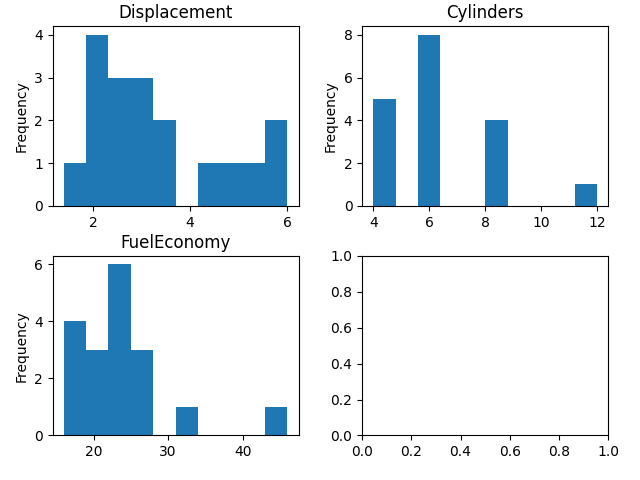

In [27]:
features = ['Displacement', 'Cylinders', 'FuelEconomy']
plot_hist(df=imputed, features=features, n_rows=2, n_cols=2)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

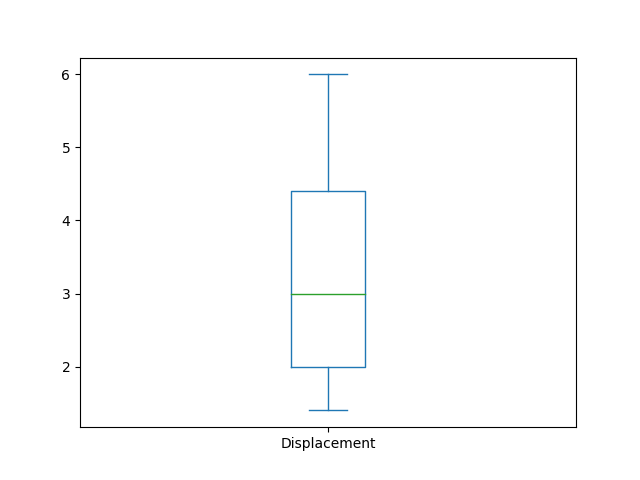

In [43]:
plt.clf()
imputed['Displacement'].plot.box()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

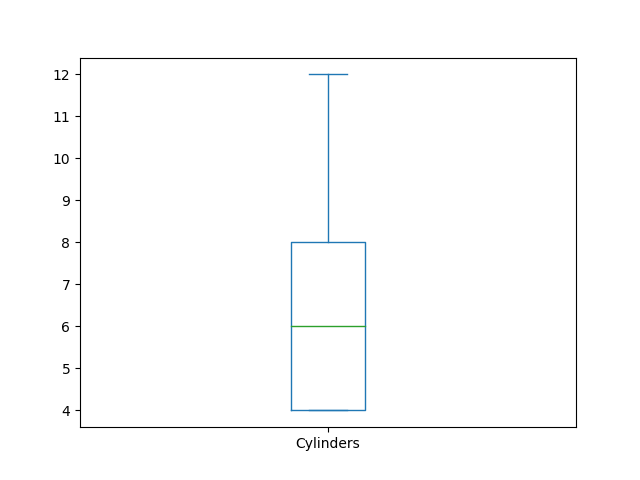

In [45]:
plt.clf()
imputed['Cylinders'].plot.box()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

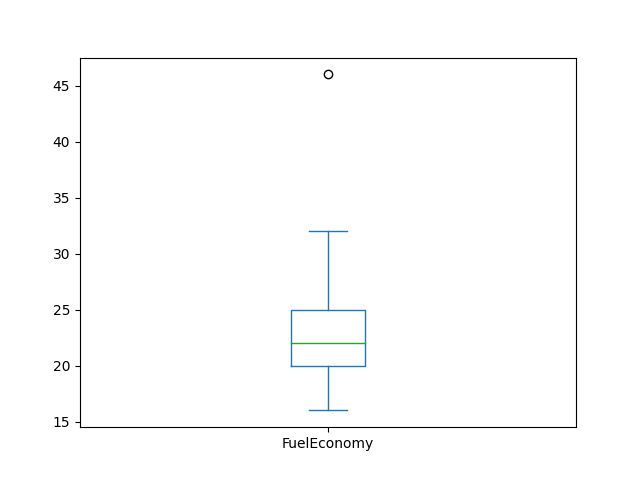

In [46]:
plt.clf()
imputed['FuelEconomy'].plot.box()
%matplot plt

Let's check out the record with the highest MPG.

In [48]:
imputed[imputed.FuelEconomy >= 45]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    Id Manufacturer            Model EngineType  Displacement  Cylinders  FuelEconomy
15  15       Toyota  CAMRY HYBRID LE  Aspirated           2.5        4.0         46.0

In [28]:
imputed[imputed.FuelEconomy > 40]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    Id Manufacturer            Model EngineType  Displacement  Cylinders  FuelEconomy
15  15       Toyota  CAMRY HYBRID LE  Aspirated           2.5        4.0         46.0

That is a hybrid car and it can be considered an outlier since the rest of the cars run on gas. Let's drop this record as outlier.

In [29]:
no_outliers = imputed[imputed.FuelEconomy < 40]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's redraw the histograms to see how the distributions changed after dropping the outliers.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

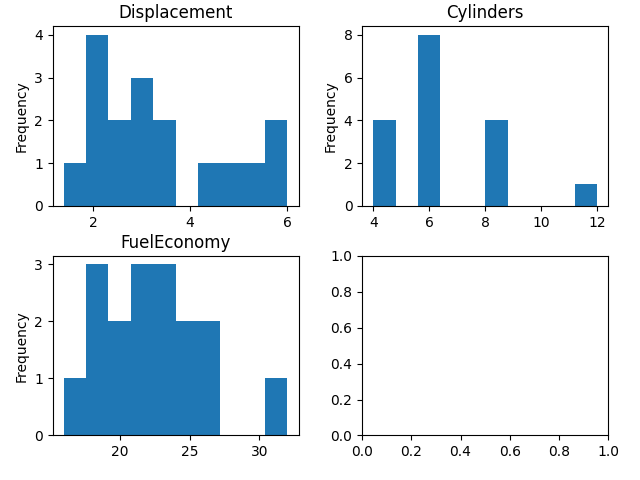

In [30]:
plot_hist(df=no_outliers, features=features, n_rows=2, n_cols=2)
%matplot plt

## Exploring descriptive statistics

In [31]:
#describe numeric features
descriptive_stats = no_outliers.describe()
descriptive_stats

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

              Id  Displacement  Cylinders  FuelEconomy
count  17.000000     17.000000  17.000000    17.000000
mean    9.764706      3.323529   6.382353    22.269896
std     6.777992      1.402466   2.025458     3.955093
min     0.000000      1.400000   4.000000    16.000000
25%     4.000000      2.000000   6.000000    20.000000
50%    10.000000      3.000000   6.000000    22.000000
75%    14.000000      4.400000   8.000000    24.000000
max    21.000000      6.000000  12.000000    32.000000

In [32]:
#statistics grouped by number of cylinders
(
    no_outliers[features]
    .groupby('Cylinders')
    .agg(count = ('Displacement', 'count'),
        MPG_avg = ('FuelEconomy', 'mean'),
         Disp_avg = ('Displacement', 'mean'),
         MPG_stdev = ('FuelEconomy', 'stddev'),
         Disp_stdev = ('Displacement', 'stddev')
        )
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

           count    MPG_avg  Disp_avg  MPG_stdev  Disp_stdev
Cylinders                                                   
6.25           2  29.500000     1.700   3.535534    0.424264
6.00           6  22.000000     3.100   1.673320    0.309839
4.00           4  24.147059     2.125   1.740023    0.250000
8.00           4  18.750000     5.000   1.500000    0.547723
12.00          1  16.000000     6.000        NaN         NaN

## Computing correlations

In [33]:
no_outliers[features].corr()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

              Displacement  Cylinders  FuelEconomy
Displacement      1.000000   0.841516    -0.849268
Cylinders         0.841516   1.000000    -0.602156
FuelEconomy      -0.849268  -0.602156     1.000000

## Data Visualization

### Histograms
* By default, spark uses the first 1000 rows to draw charts but <a href='https://spark.apache.org/docs/latest/api/python/user_guide/pandas_on_spark/options.html' target='_blank'>that can be changed</a>.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

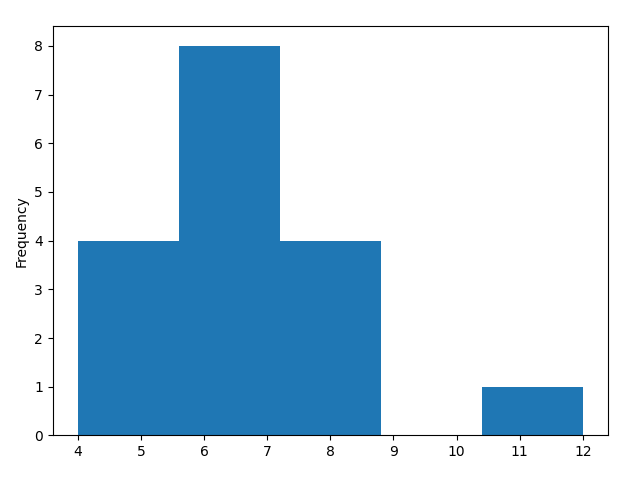

In [34]:
#clear the canvas
plt.clf()
no_outliers['Cylinders'].hist(bins=5)
%matplot plt

### Visualizing interactions between features

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

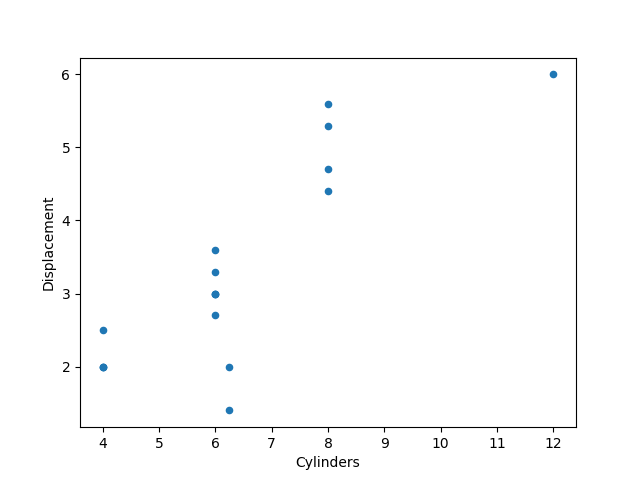

In [35]:
plt.clf()
no_outliers.plot.scatter('Cylinders', 'Displacement')
%matplot plt

### Box Plot

In [36]:
plt.clf()
no_outliers[[x for x in no_outliers.columns if x != 'Id']].boxplot()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
'DataFrame' object has no attribute 'name'
Traceback (most recent call last):
  File "/mnt1/yarn/usercache/livy/appcache/application_1718239785956_0002/container_1718239785956_0002_01_000001/pyspark.zip/pyspark/pandas/frame.py", line 1002, in boxplot
    return self.plot.box(**kwds)
  File "/mnt1/yarn/usercache/livy/appcache/application_1718239785956_0002/container_1718239785956_0002_01_000001/pyspark.zip/pyspark/pandas/plot/core.py", line 899, in box
    return self(kind="box", **kwds)
  File "/mnt1/yarn/usercache/livy/appcache/application_1718239785956_0002/container_1718239785956_0002_01_000001/pyspark.zip/pyspark/pandas/plot/core.py", line 578, in __call__
    return plot_backend.plot_pandas_on_spark(plot_data, kind=kind, **kwargs)
  File "/mnt1/yarn/usercache/livy/appcache/application_1718239785956_0002/container_1718239785956_0002_01_000001/pyspark.zip/pyspark/pandas/plot/matplotlib.py", line 562, in plot_pandas_on_spark
    return plot_frame(data=data, 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

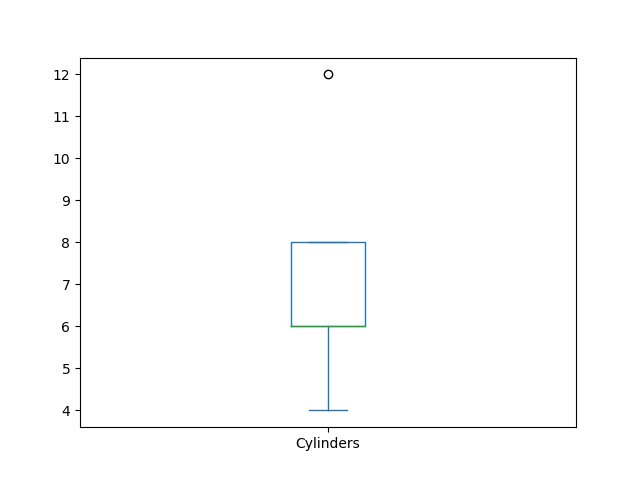

In [37]:
plt.clf()
no_outliers['Cylinders'].plot.box()
%matplot plt

Another option is to use a pandas df. We first get a sample of the datset for visualization. In this case, since the dataset is small, I set the sampling fraction to 1.0 (100%) but you need to set it to a smaller value if your dataset is large since the sample is converted to a Pandas dataframe stored on the driver.

In [38]:
#fraction must be float
sampling_fraction = 1.0
sample_df = no_outliers.sample(frac=sampling_fraction).to_pandas()
sample_df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    Id  Manufacturer  ... Cylinders FuelEconomy
1    1  Aston Martin  ...     12.00        16.0
5    5           BMW  ...      6.25        27.0
6    6           BMW  ...      6.00        23.0
4    4           BMW  ...      4.00        26.0
20  20           BMW  ...      8.00        18.0

[5 rows x 7 columns]
/mnt1/yarn/usercache/livy/appcache/application_1718239785956_0002/container_1718239785956_0002_01_000001/pyspark.zip/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

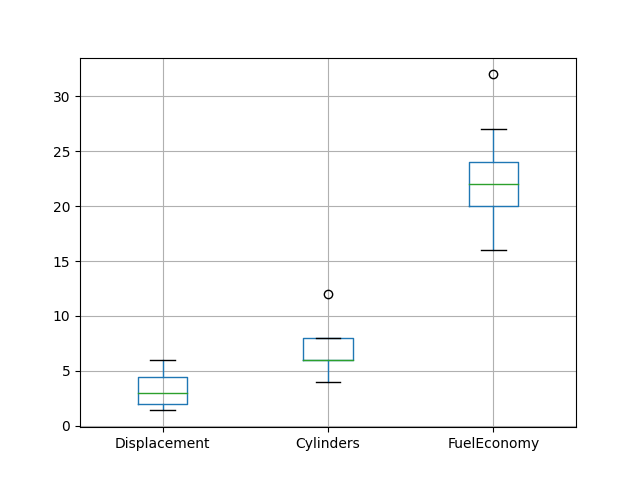

In [39]:
plt.clf()
sample_df[[x for x in sample_df.columns if x != 'Id']].boxplot()
%matplot plt

### Bar chart

In [40]:
no_outliers['Cylinders'].value_counts()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

6.00     6
4.00     4
8.00     4
6.25     2
12.00    1
Name: Cylinders, dtype: int64

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

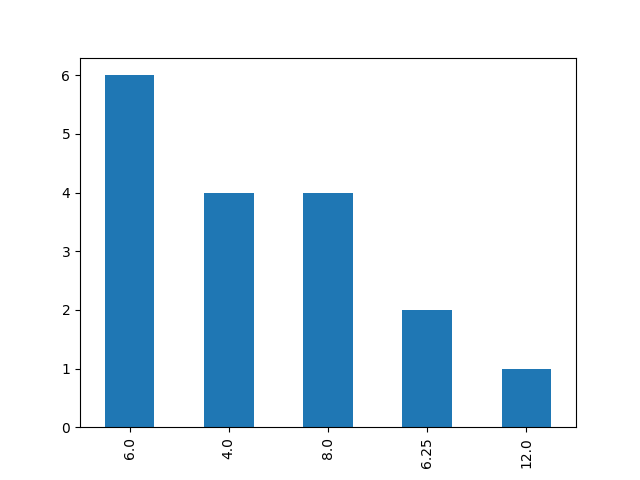

In [41]:
plt.clf()
cylinder = no_outliers['Cylinders'].value_counts().plot.bar()
%matplot plt

## Class Exercise
Draw a bar chart to show average MPG for each number of cylinders.

In [ ]:
no_outliers.groupby('Cylinders')['FuelEconomy'].mean().plot.bar()
%matplot plt

### Data Visualization Summary
<b>Please note that all these charts are based on a sample of the data and may not truely represent the real distribution of the data.</b>